In [1]:
import scipy
import fitsio
import smatch
import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import hpgeom
import numba
import tqdm

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
_ed = fitsio.read("des_exposure_data.fits")

In [3]:
_ed = np.sort(_ed, order="mjd_obs")

In [4]:
_ed.shape

(100802,)

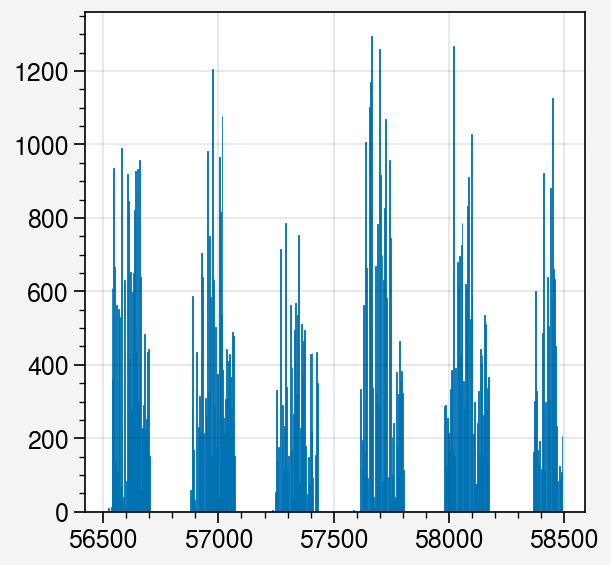

In [5]:
fig, axs = pplt.subplots()

axs.hist(_ed["mjd_obs"], bins=500);

In [198]:
from silly_cal.models import nights_with_mirror_rho

nside = 256

msk1 = (
    (_ed["mjd_obs"] < 56800) & (_ed["dec"] < -50)
)
msk2 = (
    (_ed["mjd_obs"] > 56800) 
    & (_ed["mjd_obs"] < 57200) 
    & (_ed["dec"] > -35)
)

bmsk = (_ed["band"] == "r")

totmsk = bmsk
# totmsk = bmsk & (_ed["mjd_obs"] < 57500)
# totmsk = bmsk & (_ed["mjd_obs"] > 57500)
# totmsk = bmsk & (msk1 | msk2)

# edata=_ed[(_ed["mjd_obs"] > 57900) & bmsk],
# edata=_ed[(_ed["mjd_obs"] > 57500) & (_ed["mjd_obs"] < 58300) & bmsk],

fd = nights_with_mirror_rho.gen_fake_data(
    edata=_ed[totmsk],
    nside=nside,
    seed=None,
    target_nstar=20e6,
    period=365*3,
)

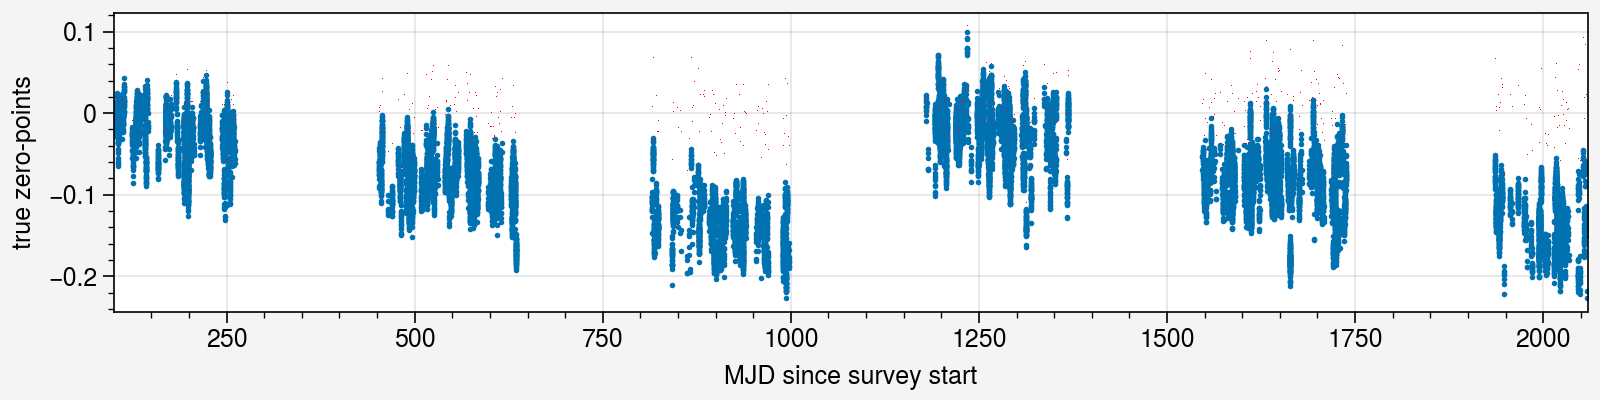

In [199]:
fig, axs = pplt.subplots(figsize=(8, 2))

axs.plot(fd["data"]["night"], fd["data"]["true_zp"], ".", markersize=2)
yv = fd["data"]["true_zp_night"][fd["data"]["inv_unight"]]
axs.plot(fd["data"]["night"], yv, ",", color="r")
axs.format(xlabel="MJD since survey start", ylabel="true zero-points")

## Optimize the Loss

In [200]:
from silly_cal.optimizers import run_amsgrad, run_laprop

# from functools import partial

# pars = nights_with_mirror.gen_guess(fd["opt_kwargs"], eps=1e-2)
# grad = np.zeros_like(pars)
# nt = numba.get_num_threads()
# tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

# def ofun(pars):
#     return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])

# ores = run_laprop(ofun, pars, 1e-3, 10000)
# ores

In [201]:
from scipy.optimize import minimize
from functools import partial

pars = nights_with_mirror_rho.gen_guess(fd["opt_kwargs"], eps=1e-1)
grad = np.zeros_like(pars)
nt = numba.get_num_threads()
tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)


def ofun_lp(pars):
    return nights_with_mirror_rho.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])

def ofun(pars):
    return nights_with_mirror_rho.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[0]

def ofun_jac(pars):
    return nights_with_mirror_rho.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[1].copy()

bounds = [(None, None) for g in grad]
bounds[0] = (0, 1.0)

ores = run_laprop(ofun_lp, pars, 1e-3, 10000)

# with tqdm.trange(1000, ncols=80) as itr:
#     for _ in itr:
#         res = minimize(
#             ofun, 
#             pars, 
#             method="L-BFGS-B", 
#             jac=ofun_jac, 
#             bounds=bounds, 
#             options=dict(
#                 disp=-1,
#                 ftol=0,
#                 gtol=0,
#             ), 
#         )
#         pars = res["x"]
#         itr.set_description("chi2/dof = %e" % res["fun"])
# res = minimize(
#     ofun, res["x"], method="L-BFGS-B", jac=ofun_jac, options=dict(disp=10), bounds=bounds
# )
res = minimize(
    ofun, 
    ores["x"], 
    method="L-BFGS-B", 
    jac=ofun_jac, 
    bounds=bounds, 
    options=dict(
        disp=1,
        ftol=0,
        gtol=0,
    ), 
)
res["x"] = nights_with_mirror_rho.zero_to_sstar(res["x"], **fd["opt_kwargs"])
res

chi2/dof = 9.04882355e-01:  18%|█▉         | 1803/10000 [01:14<05:40, 24.08it/s]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       124778     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04887D-01    |proj g|=  5.92281D-01

At iterate    1    f=  9.04874D-01    |proj g|=  4.39432D-01

At iterate    2    f=  9.04853D-01    |proj g|=  1.33745D-01

At iterate    3    f=  9.04852D-01    |proj g|=  6.76035D-02

At iterate    4    f=  9.04852D-01    |proj g|=  8.86091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****      4     21      4     0     0   8.861D-02   9.049D-01
  F =  0.90485248590886913     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.9048524859088691
        x: [ 9.696e-01  3.859e-02 ... -1.527e-03  7.548e-03]
      nit: 4
      jac: [ 5.909e-02 -3.206e-02 ... -1.696e-06 -1.601e-06]
     nfev: 21
     njev: 21
 hess_inv: <124778x124778 LbfgsInvHessProduct with dtype=float64>

In [202]:
res["x"] = nights_with_mirror_rho.zero_to_survey(res["x"], **fd["opt_kwargs"])
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.9048524859088691
        x: [ 9.696e-01  3.980e-02 ... -2.737e-03  6.338e-03]
      nit: 4
      jac: [ 5.909e-02 -3.206e-02 ... -1.696e-06 -1.601e-06]
     nfev: 21
     njev: 21
 hess_inv: <124778x124778 LbfgsInvHessProduct with dtype=float64>

In [203]:
fdd = fd["data"]

In [204]:
(
    (fd["params"]["rho_night"], res["x"][0]), 
    (fd["params"]["global_cal"], res["x"][1]), 
    (fd["data"]["true_tel_eff"], res["x"][2:2+fd["data"]["true_tel_eff"].shape[0]]),
    (
        fd["data"]["true_star"][fd["data"]["isstar"]], 
         res["x"][
             2 
             + fd["opt_kwargs"]["nyear"] 
             + fd["opt_kwargs"]["nnight"]
             + fd["opt_kwargs"]["nexp"]
             + fd["data"]["isstar"]
         ]
    )
)

((0.891, 0.9696005217454006),
 (0, 0.03979641461128053),
 (array([-0.14372442, -0.15460407]), array([-0.21421131, -0.18297851])),
 (0.0, -0.0012097408121713009))

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import healsparse as hsp

import skyproj

In [206]:
hmap = hsp.HealSparseMap.make_empty(32, nside, np.float64)

In [207]:
est_star = res["x"][2+fd["opt_kwargs"]["nyear"] + fd["opt_kwargs"]["nnight"]+fd["opt_kwargs"]["nexp"]:]

dstar = (est_star - fdd["true_star"]) * 1e3

hmap.update_values_pix(fdd["true_star_nest_ind"], dstar)

In [208]:
msk = fdd["star_dec"] < -40.0

(
    np.mean(dstar[msk]), 
    np.std(dstar[msk])/np.sqrt(np.sum(msk)), 
    np.mean(dstar[~msk]), 
    np.std(dstar[~msk])/np.sqrt(np.sum(~msk))
)

(0.005282383403081893,
 0.010733420137151421,
 -0.004274016233249251,
 0.01077273373376285)

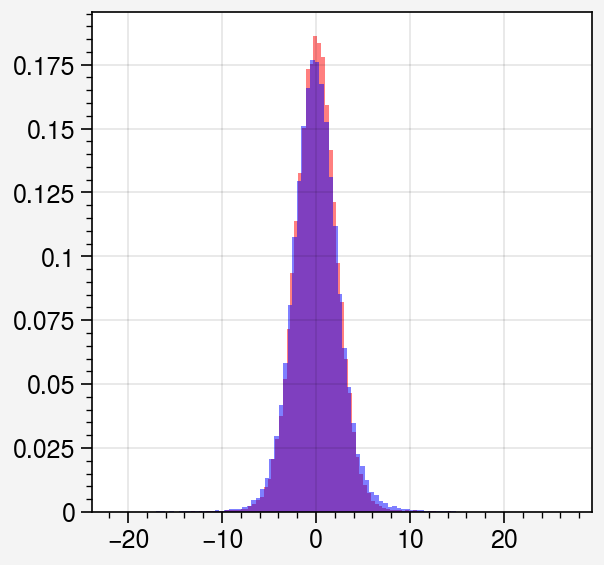

In [209]:
fig, axs = pplt.subplots()

axs.hist(dstar[msk], bins=100, density=True, alpha=0.5, color="r")
axs.hist(dstar[~msk], bins=100, density=True, alpha=0.5, color="b");

In [210]:
from mattspy.stats import mad

fac = np.sqrt(fd["params"]["target_nstar"] / dstar.shape[0])

np.mean(dstar), mad(dstar), mad(dstar) * fac

(1.5916488874544464e-16, 2.2132329167466502, 30.86237999898843)

In [211]:
def get_true_zp(fd):
    rho_night = fd["params"]["rho_night"]
    true_zp_night = fd["data"]["true_zp_night"]
    true_zp_nse = fd["data"]["true_zp_nse"]
    true_tel_eff = fd["data"]["true_tel_eff"]
    night_in_year = fd["data"]["night_in_year"]
    inv_unight = fd["data"]["inv_unight"]
    inv_uyear = fd["data"]["inv_uyear"]
    
    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    return (
        sqrt_rho_night * true_zp_night[inv_unight]
        + rho_night_fac * true_zp_nse
        + true_tel_eff[inv_uyear] * night_in_year
        + fd["params"]["global_cal"]
    )


def get_est_zp(pars, fd):
    nnight = fd["data"]["true_zp_night"].shape[0]
    nexp = fd["data"]["true_zp_nse"].shape[0]
    nyear = fd["data"]["true_tel_eff"].shape[0]
    
    rho_night = pars[0]
    global_cal = pars[1]
    tel_eff = pars[2:2+nyear]
    zp_night = pars[2+nyear:2+nyear+nnight]
    zp_nse = pars[2+nyear+nnight:2+nyear+nnight+nexp]

    night_in_year = fd["data"]["night_in_year"]
    inv_unight = fd["data"]["inv_unight"]
    inv_uyear = fd["data"]["inv_uyear"]
    
    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    return (
        sqrt_rho_night * zp_night[inv_unight]
        + rho_night_fac * zp_nse
        + tel_eff[inv_uyear] * night_in_year
        + global_cal
    )

true_zp = get_true_zp(fd)
est_zp = get_est_zp(res["x"], fd)

dzp = (est_zp - true_zp) * 1e3

from mattspy.stats import mad

np.mean(dzp), mad(dzp)

(0.02749966507451425, 1.1789333471193453)

In [212]:
msk = fd["data"]["exp_dec"] < -40

np.mean(dzp[msk]), mad(dzp[msk])/np.sqrt(np.sum(msk)), np.mean(dzp[~msk]), mad(dzp[~msk])/np.sqrt(np.sum(~msk))

(-0.002032753805580829,
 0.011807134725358116,
 0.052649144655926926,
 0.010981881373031955)

In [213]:
_nside = 16

exp_hmap = hsp.HealSparseMap.make_empty(_nside, _nside, np.float64)
nexp_hmap = hsp.HealSparseMap.make_empty(_nside, _nside, np.float64)

exp_hmap.update_values_pos(fd["data"]["exp_ra"], fd["data"]["exp_dec"], dzp, operation="add")
nexp_hmap.update_values_pos(fd["data"]["exp_ra"], fd["data"]["exp_dec"], 1.0, operation="add")

exp_hmap_vals = exp_hmap.get_values_pix(exp_hmap.valid_pixels)
nexp_hmap_vals = nexp_hmap.get_values_pix(nexp_hmap.valid_pixels)

exp_hmap_vals /= nexp_hmap_vals

_ra, _dec = exp_hmap.valid_pixels_pos()

mn_exp_hmap = hsp.HealSparseMap.make_empty(_nside, _nside, np.float64)
mn_exp_hmap.update_values_pos(_ra, _dec, exp_hmap_vals)

(<matplotlib.colorbar.Colorbar at 0x152dbd3f0>,
 <AxesHostAxes:xlabel='exposure $\\Delta mag$ [mmag]'>)

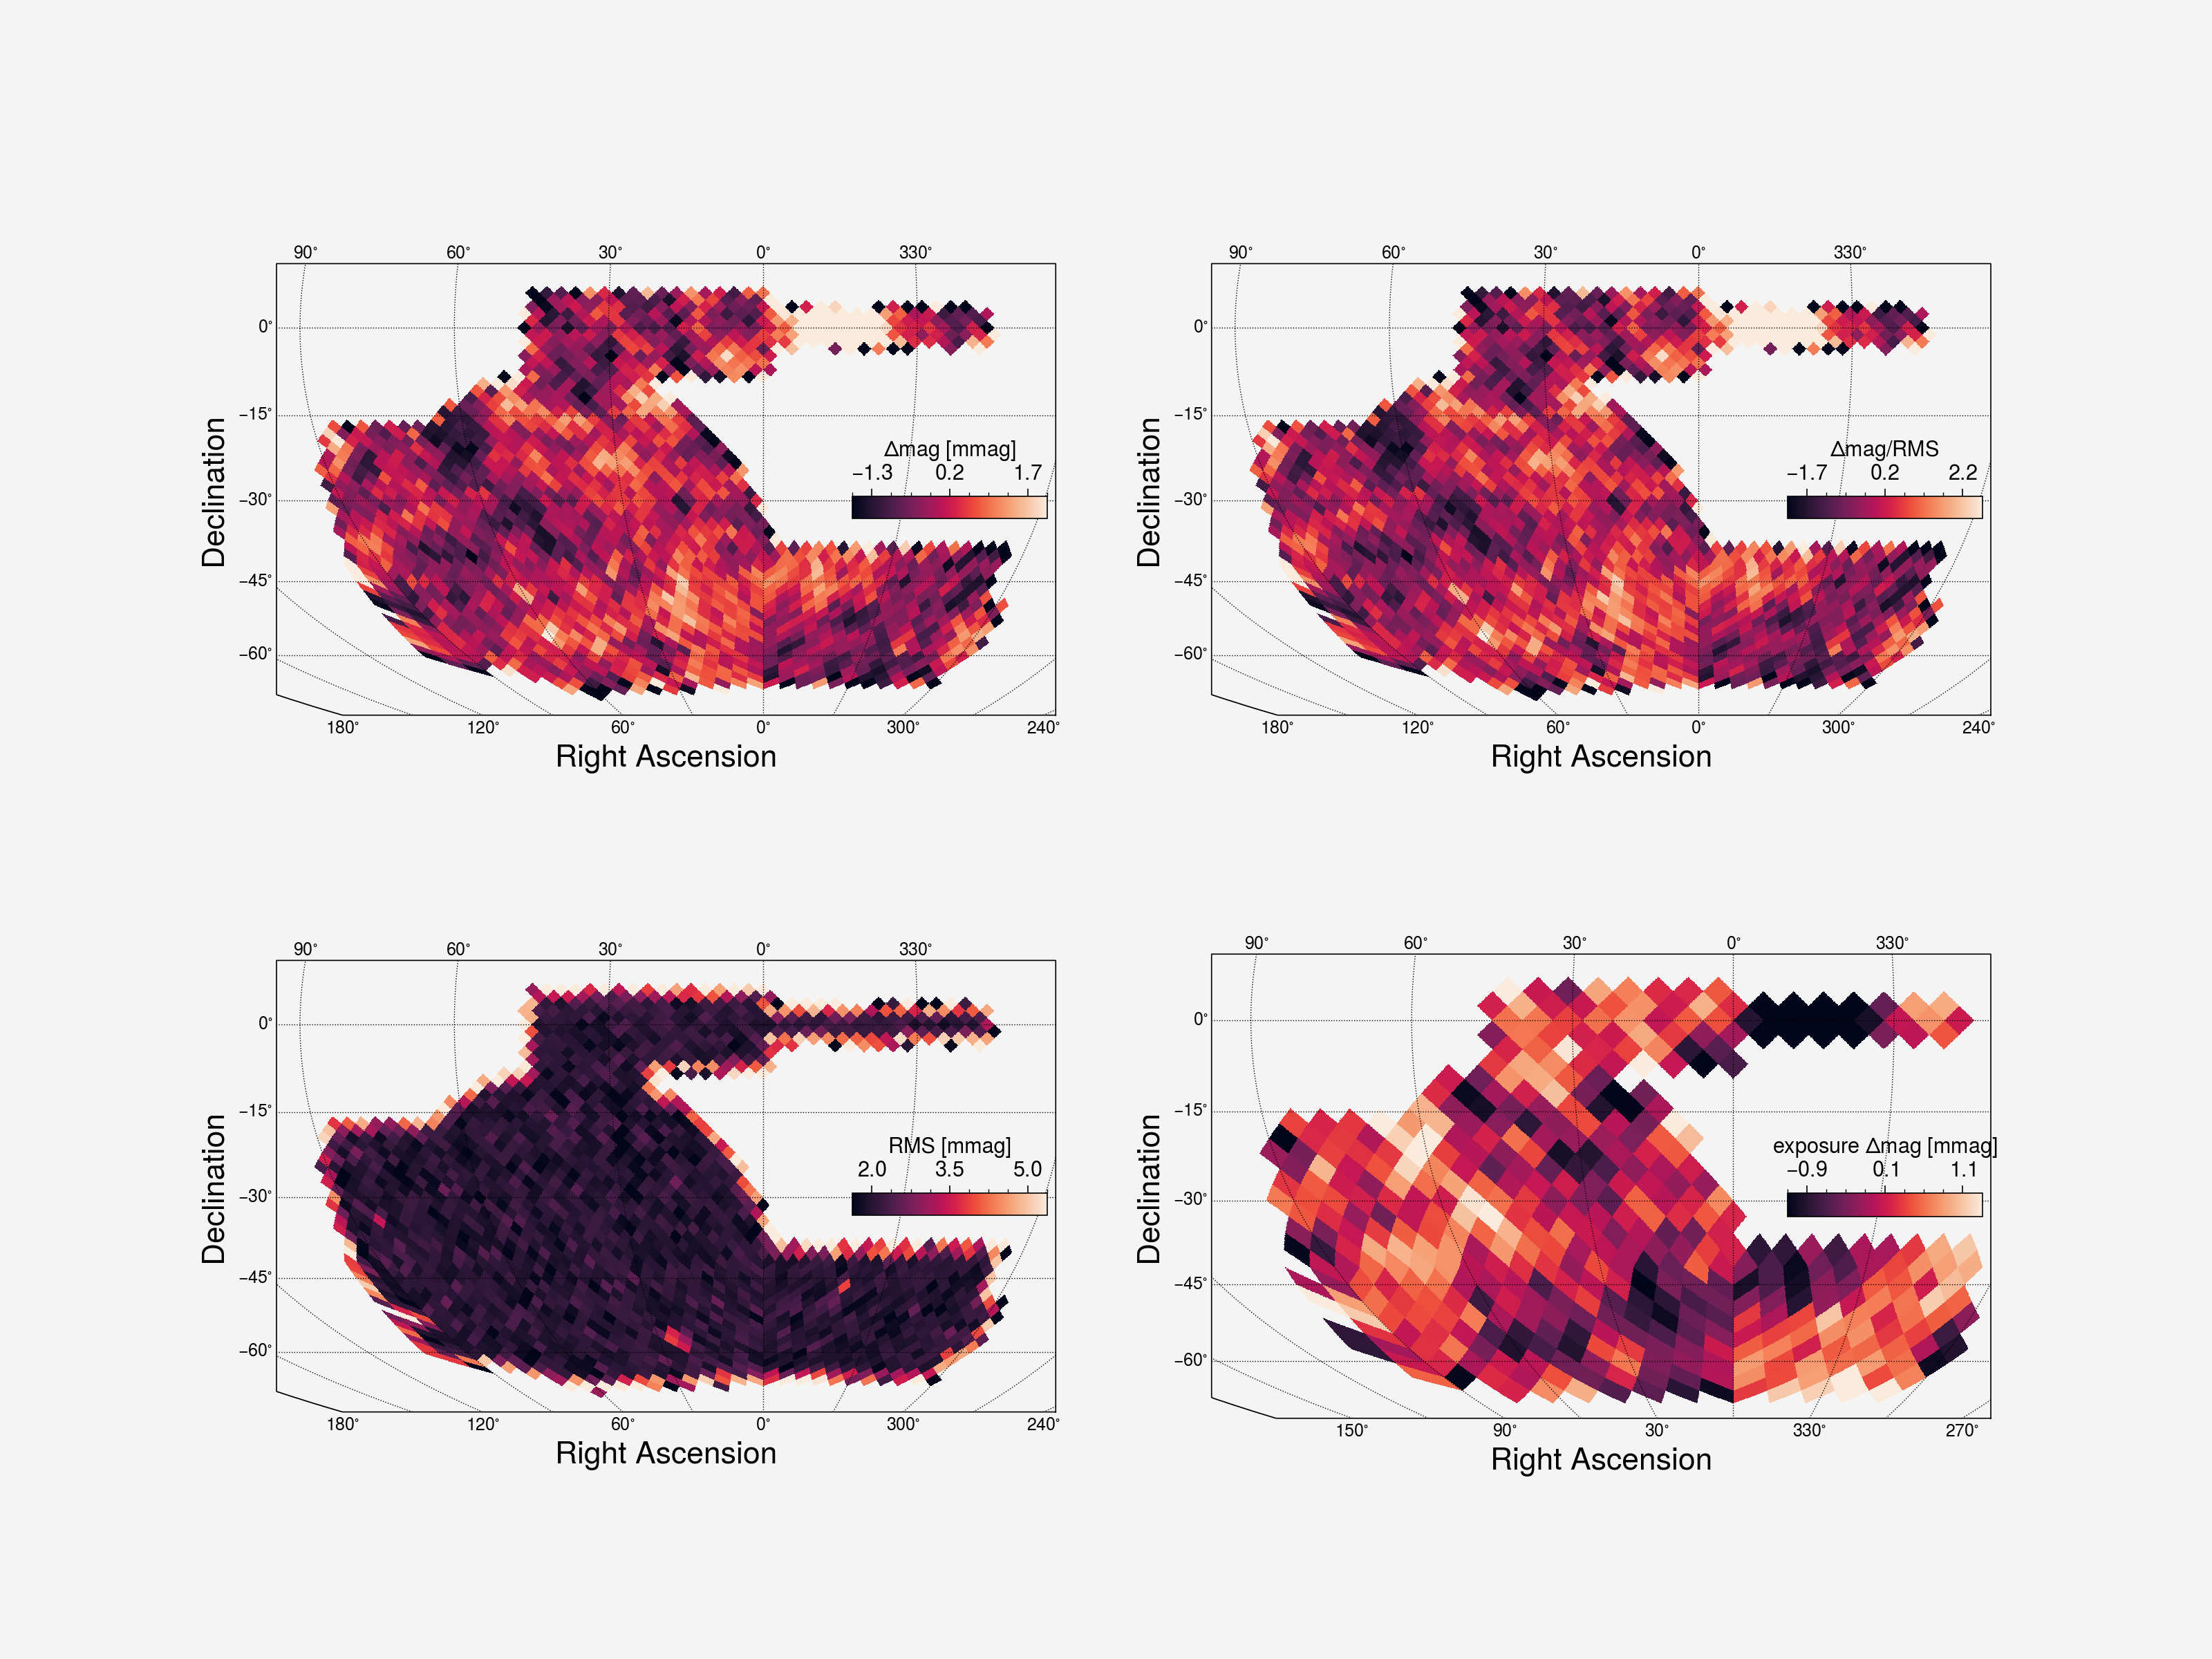

In [214]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 12), squeeze=False)

global_rms = mad(dstar)

_nside = 32
mn_map = hmap.degrade(_nside, reduction="mean")
sd_map = hmap.degrade(_nside, reduction="std")
mean_sd = np.median(sd_map.get_values_pix(sd_map.valid_pixels))
mad_mn_map = mad(mn_map.get_values_pix(mn_map.valid_pixels))

sp = skyproj.McBrydeSkyproj(ax=axs[0, 0])
sp.draw_hspmap(mn_map, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag$ [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[0, 1])
sp.draw_hspmap(mn_map / mad_mn_map, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag/RMS$")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
sp.draw_hspmap(sd_map, cmap="rocket")
sp.draw_inset_colorbar(label="RMS [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 1])
sp.draw_hspmap(mn_exp_hmap, cmap="rocket")
sp.draw_inset_colorbar(label="exposure $\Delta mag$ [mmag]")